Крутов Андрей

## Задание 2. Идентификация мошенников среди покупателей в онлайн-магазине

#### Второе задание не является обязательным. Цель этого задания - предоставить возможность решить целостную задачу, аналогичную реальным рабочим проектам и получить развернутый фидбек и советы от лектора.

#### Customers_final_ex.csv — данные о покупателях
Описание:
* Customer_id — уникальный идентификатор учетной записи клиента
* age — возраст клиентского счета в месяцах (может быть float)
* num_s — количество посылок, отправленных на адрес, по которому покупатель не проживает в течение последнего месяца
* num_dev — количество различных физических устройств (смартфонов, планшетов, ПК), связанных на данный момент с учетной записью
* gender — мужчина, женщина, другое или нет информации
* Preferred color — предпочтительный цвет заказчика

#### Transactional_info_new.csv — данные о покупках этих покупателей в последнем месяце
Описание:
* transaction_id — уникальный идентификатор покупки
* Dist — расстояние между адресом доставки и домашним адресом в км
* payment_t — тип платежа: 0 — безопасный (кредитные карты, PayPal и т. д.) 1— небезопасный (счет, рассрочка)
* count_dev_is_shop — страна, в которой находится устройство, с которого была совершена транзакция, идентифицируется по IP-адресу, идентична стране магазина (0 — да, 1 — нет)
* basket — стоимость покупки
* product_type — ценность товара в зависимости от типа товара
* Fraudulent_Trans — отметка, считалась ли транзакция мошеннической (истинное значение)
* Customer_id — идентификатор учетной записи клиента, в которой была создана эта транзакция
* Day_of_Week — день недели, когда была создана транзакция (0 - воскресенье, 1 - понедельник и тд)

#### Задание: 
* Проведите анализ полученных данных. Выберите метод анализа из изученных на курсе, обоснуйте свой выбор.
* Проанализируйте, какие факторы важны для находки покупок мошенников, какие нет? 
* Создайте модель, которая будет предсказывать на будущее Fraudulent_Trans. 
* Пришлите файл jupyter notebook с анализом и детальным описанием своей работы: какие методы вы использовали, какие теории и гипотезы вы выдвигали, как вы их проверяли и к каким результатам пришли.

Решаем задачу классификации, так как надо предсказать принадлежность наблюдения к классу 1 или 0 (мошенничество или нет)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [2]:
customers = pd.read_csv('d://robot_dreams/statistics for DS/customers.csv', index_col=0).reset_index()

In [3]:
customers.head(2)

,Customer_id,age,num_s,num_dev,Preferred_col,Gender
0,customer_448,35.724517,2,3,blue,f
1,customer_183,17.396979,1,4,brown,f


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer_id    450 non-null    object 
 1   age            450 non-null    float64
 2   num_s          450 non-null    int64  
 3   num_dev        450 non-null    int64  
 4   Preferred_col  450 non-null    object 
 5   Gender         450 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 21.2+ KB


In [5]:
customers.shape

(450, 6)

In [6]:
transactions = pd.read_csv('d://robot_dreams/statistics for DS/transactions_ex.csv', index_col=0).reset_index()

In [7]:
transactions.head(2)

,transaction_id,Dist,payment_t,count_dev_is_shop,basket,product_type,Customer_id,Day_of_week,Fraudulent_trans
0,transaction_0,105.926953,0.0,0.0,46.390320,0,customer_448,5,0.0
1,transaction_1,185.256711,1.0,0.0,60.701211,1,customer_183,0,0.0


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     1000 non-null   object 
 1   Dist               1000 non-null   float64
 2   payment_t          1000 non-null   float64
 3   count_dev_is_shop  1000 non-null   float64
 4   basket             1000 non-null   float64
 5   product_type       1000 non-null   int64  
 6   Customer_id        1000 non-null   object 
 7   Day_of_week        1000 non-null   int64  
 8   Fraudulent_trans   1000 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 70.4+ KB


In [9]:
transactions.shape

(1000, 9)

In [10]:
#Объединим наборы
merged_df = transactions.merge(customers, on='Customer_id', how='left')

In [11]:
merged_df.head(3)

,transaction_id,Dist,payment_t,count_dev_is_shop,basket,product_type,Customer_id,Day_of_week,Fraudulent_trans,age,num_s,num_dev,Preferred_col,Gender
0,transaction_0,105.926953,0.0,0.0,46.390320,0,customer_448,5,0.0,35.724517,2.0,3.0,blue,f
1,transaction_1,185.256711,1.0,0.0,60.701211,1,customer_183,0,0.0,17.396979,1.0,4.0,brown,f
2,transaction_2,71.725825,0.0,1.0,79.602869,0,customer_261,2,0.0,37.054879,3.0,4.0,white,m


In [12]:
merged_df['Customer_id'].isnull().sum()

0

В колонке Customer_id нет пропущенных значений

In [13]:
merged_df = merged_df.fillna(0)#заполним пропуски нулями

Id транзакции и покупателя - это значения, которые присваиваютс системой, значит их можно отбросить

In [14]:
merged_df = merged_df.drop(['transaction_id', 'Customer_id'], axis=1)

In [15]:
data = merged_df
data['Fraudulent_trans'] = data['Fraudulent_trans'].astype('int64')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dist               1000 non-null   float64
 1   payment_t          1000 non-null   float64
 2   count_dev_is_shop  1000 non-null   float64
 3   basket             1000 non-null   float64
 4   product_type       1000 non-null   int64  
 5   Day_of_week        1000 non-null   int64  
 6   Fraudulent_trans   1000 non-null   int64  
 7   age                1000 non-null   float64
 8   num_s              1000 non-null   float64
 9   num_dev            1000 non-null   float64
 10  Preferred_col      1000 non-null   object 
 11  Gender             1000 non-null   object 
dtypes: float64(7), int64(3), object(2)
memory usage: 101.6+ KB


In [17]:
data['gender_cat'] = np.where(data['Gender']=='m', 1,0)# m=1, f=0 - закодируем пол покупателя
data = data.drop('Gender', axis=1)

In [18]:
data.head(2)

,Dist,payment_t,count_dev_is_shop,basket,product_type,Day_of_week,Fraudulent_trans,age,num_s,num_dev,Preferred_col,gender_cat
0,105.926953,0.0,0.0,46.390320,0,5,0,35.724517,2.0,3.0,blue,0
1,185.256711,1.0,0.0,60.701211,1,0,0,17.396979,1.0,4.0,brown,0


Переменная Preferred_col - не числовая, ее необходимо закодировать при помощи one-hot-encoding. Так как задание выполняется в рамках курса, то просто отбросим эту переменную.

In [19]:
data = data.drop('Preferred_col', axis=1)

Посмотрим на баланс классов

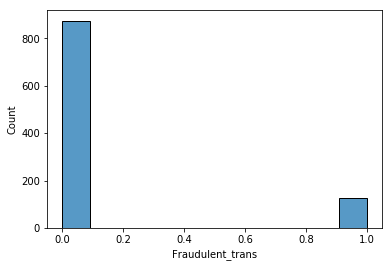

In [21]:
_ = sns.histplot(data['Fraudulent_trans'])

Классы не сбалансированы

Построим графики рассения оставшихся переменных и целевой переменной

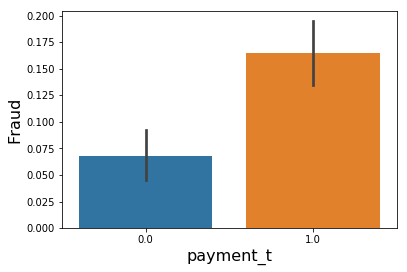

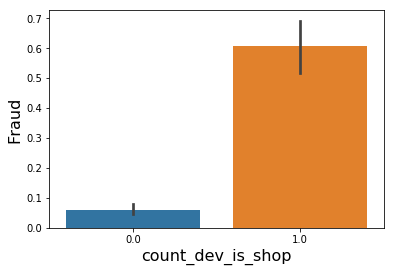

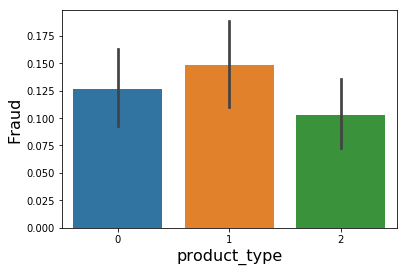

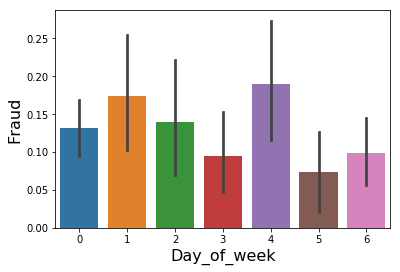

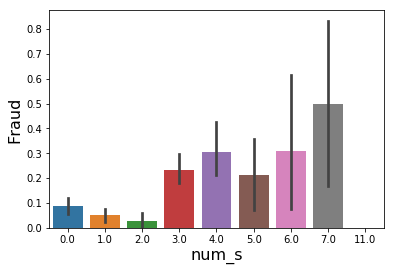

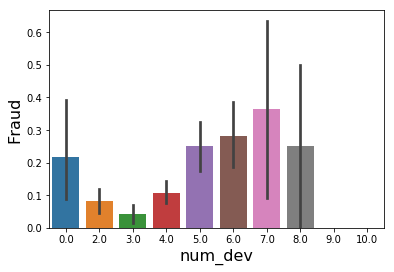

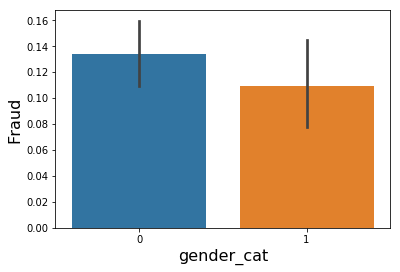

In [23]:
cols = ['payment_t', 'count_dev_is_shop', 'product_type', 'Day_of_week', 'num_s', 'num_dev', 'gender_cat']# выберем дискретные переменные
for i in cols:#построим долю мошенничества в зависимости от переменной
    fig, ax = plt.subplots()
    sns.barplot(data=data, x=i, y='Fraudulent_trans')
    ax.set_xlabel(i,size=16)
    ax.set_ylabel('Fraud',size=16)

Исходя из графиков, при построении модели будем учитывать все указанные параметры

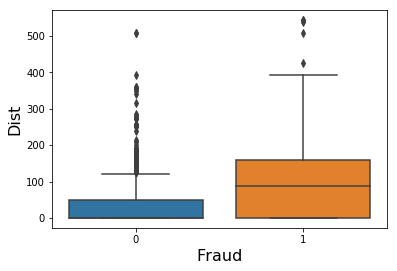

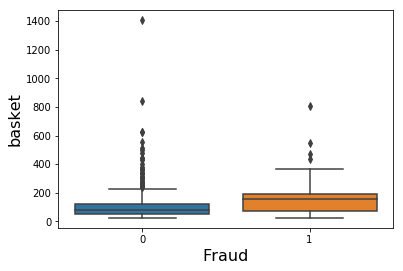

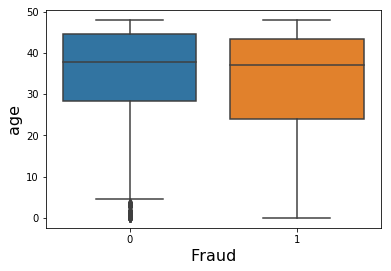

In [24]:
cols = ['Dist', 'basket', 'age']# выберем непрерывные переменные
for i in cols:#построим долю мошенничества в зависимости от переменной
    fig, ax = plt.subplots()
    sns.boxplot(x=data['Fraudulent_trans'], y=data[i])
    
    ax.set_xlabel('Fraud',size=16)
    ax.set_ylabel(i,size=16)

Мошенничество не зависит от возраста. В данных по корзине есть большой выброс, уберем его.

In [25]:
data = data.drop(data['basket'].idxmax(),axis=0)#по индексу убираем запись с наибольшим значением basket

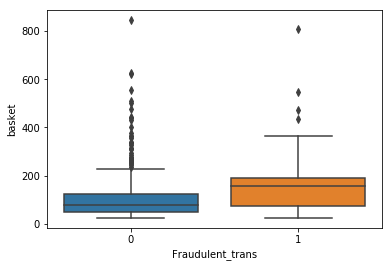

In [26]:
_ = sns.boxplot(x=data['Fraudulent_trans'], y=data['basket'])

In [27]:
data = data.drop('age', axis=1)#убрали возраст

In [28]:
target = data['Fraudulent_trans']# целевая переменная
data = data.drop('Fraudulent_trans', axis=1)#данные без целевой переменной

Проверим корреляцию данных

In [29]:
data.corr()

,Dist,payment_t,count_dev_is_shop,basket,product_type,Day_of_week,num_s,num_dev,gender_cat
Dist,1.000000,0.126793,0.374763,0.279261,0.017310,-0.044246,0.221751,0.166162,0.022427
payment_t,0.126793,1.000000,0.270514,0.114932,0.013620,0.018881,0.078127,0.049293,-0.006510
count_dev_is_shop,0.374763,0.270514,1.000000,0.301060,-0.055935,-0.091766,0.333310,0.231278,0.004273
basket,0.279261,0.114932,0.301060,1.000000,-0.032096,-0.027582,0.185796,0.180268,-0.014656
product_type,0.017310,0.013620,-0.055935,-0.032096,1.000000,0.012323,0.008683,-0.014921,-0.002315
Day_of_week,-0.044246,0.018881,-0.091766,-0.027582,0.012323,1.000000,-0.097257,-0.060116,-0.047686
num_s,0.221751,0.078127,0.333310,0.185796,0.008683,-0.097257,1.000000,0.464711,0.052128
num_dev,0.166162,0.049293,0.231278,0.180268,-0.014921,-0.060116,0.464711,1.000000,-0.002268
gender_cat,0.022427,-0.006510,0.004273,-0.014656,-0.002315,-0.047686,0.052128,-0.002268,1.000000


Нет сильно коррелирующих параметров, значит оставляем все имеющиеся признаки

Приведем данные к одному масштабу - проведем z-преобразование

In [30]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data_train = pd.DataFrame(scaled_data)
scaled_data_train.head()

,0,1,2,3,4,5,6,7,8
0,0.765422,-1.223724,-0.369484,-0.717291,-1.241490,1.022045,0.173773,-0.434187,-0.672335
1,1.770381,0.817178,-0.369484,-0.549793,-0.007412,-1.113093,-0.424846,0.242495,-0.672335
2,0.332158,-1.223724,2.706474,-0.328564,-1.241490,-0.259038,0.772393,0.242495,1.487353
3,-0.383505,0.817178,-0.369484,-0.571859,1.226667,1.449073,-1.023465,-1.110869,1.487353
4,-0.099387,0.817178,-0.369484,0.002454,1.226667,-1.113093,0.173773,-0.434187,-0.672335


#### Построим модель. Будем также использовать кросс-валидацию, так как классы сильно не сбалансированы

In [31]:
lr = LogisticRegression()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.2, random_state=42, )

In [33]:
model = lr.fit(X_train, y_train)
preds = model.predict(X_test)
f1 = np.round(f1_score(preds, y_test),5)#рассчитаем f1 метрику для нашей модели
precision = np.round(precision_score(preds, y_test),5)#precision
recall = np.round(recall_score(preds, y_test),5)#recall
print('Precision: {}, Recall: {}, f1: {}'.format(precision, recall, f1))

Precision: 0.51515, Recall: 0.89474, f1: 0.65385


Попробуем применить кросс-валидацию

In [34]:
cv = cross_validate(lr, scaled_data, target, cv=10, scoring=['recall','precision', 'f1'])

In [35]:
cv

{'fit_time': array([0.00897622, 0.00498533, 0.01000762, 0.00748229, 0.00498629,
        0.00397587, 0.00498676, 0.00498438, 0.00302172, 0.        ]),
 'score_time': array([0.004987  , 0.00398922, 0.00694847, 0.00402355, 0.00396633,
        0.00395751, 0.0039947 , 0.00498891, 0.        , 0.        ]),
 'test_recall': array([0.66666667, 0.66666667, 0.41666667, 0.69230769, 0.30769231,
        0.46153846, 0.61538462, 0.53846154, 0.61538462, 0.5       ]),
 'test_precision': array([0.8       , 0.88888889, 0.71428571, 0.6       , 0.5       ,
        0.85714286, 0.66666667, 0.875     , 0.66666667, 0.75      ]),
 'test_f1': array([0.72727273, 0.76190476, 0.52631579, 0.64285714, 0.38095238,
        0.6       , 0.64      , 0.66666667, 0.64      , 0.6       ])}

In [36]:
cv['test_recall'].mean()

0.548076923076923

In [37]:
cv['test_precision'].mean()

0.7318650793650794

In [38]:
cv['test_f1'].mean()

0.6185969469127364

Результаты кросс-валидации будем считать более точными